In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append("..")
import gymnasium as gym
import numpy as np
from envs.two_player_dubins_car import TwoPlayerDubinsCarEnv


import jax
import jax.numpy as jnp
import haiku as hk
import optax

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import cm

In [2]:
#generate data

x_a = np.linspace(-4,4, 25)
y_a = np.linspace(-4,4, 25)
theta_a = np.linspace(0,2*np.pi, 15)

x_d = np.linspace(-4,4, 1)
y_d = np.linspace(-4,4, 1)
theta_d = np.linspace(0,2*np.pi, 1)

xx_a, yy_a, tt_a, xx_d, yy_d, tt_d = np.meshgrid(x_a, y_a, theta_a, x_d, y_d, theta_d)
grid = np.vstack([xx_a.ravel(), yy_a.ravel(), tt_a.ravel(), xx_d.ravel(), yy_d.ravel(), tt_d.ravel()]).T



In [3]:
X = []
env = TwoPlayerDubinsCarEnv()
for g in grid:
    state = env.set(*g)
    print(state)
    X.append(state.copy())


/home/apraka15/Desktop/Projects/Reach-Avoid/gym-examples/.env/lib/python3.9/site-packages/gym/spaces/box.py:127: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


{'attacker': array([-4., -4.,  0.], dtype=float32), 'defender': array([-4., -4.,  0.], dtype=float32)}
{'attacker': array([-4.        , -4.        ,  0.44879895], dtype=float32), 'defender': array([-4., -4.,  0.], dtype=float32)}
{'attacker': array([-4.       , -4.       ,  0.8975979], dtype=float32), 'defender': array([-4., -4.,  0.], dtype=float32)}
{'attacker': array([-4.       , -4.       ,  1.3463968], dtype=float32), 'defender': array([-4., -4.,  0.], dtype=float32)}
{'attacker': array([-4.       , -4.       ,  1.7951958], dtype=float32), 'defender': array([-4., -4.,  0.], dtype=float32)}
{'attacker': array([-4.       , -4.       ,  2.2439947], dtype=float32), 'defender': array([-4., -4.,  0.], dtype=float32)}
{'attacker': array([-4.       , -4.       ,  2.6927936], dtype=float32), 'defender': array([-4., -4.,  0.], dtype=float32)}
{'attacker': array([-4.       , -4.       ,  3.1415927], dtype=float32), 'defender': array([-4., -4.,  0.], dtype=float32)}
{'attacker': array([-4.   

In [4]:
X[:5]

[{'attacker': array([-4., -4.,  0.], dtype=float32),
  'defender': array([-4., -4.,  0.], dtype=float32)},
 {'attacker': array([-4.        , -4.        ,  0.44879895], dtype=float32),
  'defender': array([-4., -4.,  0.], dtype=float32)},
 {'attacker': array([-4.       , -4.       ,  0.8975979], dtype=float32),
  'defender': array([-4., -4.,  0.], dtype=float32)},
 {'attacker': array([-4.       , -4.       ,  1.3463968], dtype=float32),
  'defender': array([-4., -4.,  0.], dtype=float32)},
 {'attacker': array([-4.       , -4.       ,  1.7951958], dtype=float32),
  'defender': array([-4., -4.,  0.], dtype=float32)}]

In [5]:
# %%capture
# #generate data
# env = TwoPlayerDubinsCarEnv()

# state = env.reset()
# X = []
# y = []
# for i in range(20000):
#     for player in env.players:
#         state = env.reset()
#         action = env.action_space[player].sample() 
#         X.append(np.hstack([state['attacker'], state['defender']]))
#         r = env.sample(state, action, player,0.5)
#         y.append(r)

# X = np.array(X)
# y = np.array(y)

# print(X[:5])
# print(y[:5])


In [6]:
X[2000]

{'attacker': array([-1.3333334, -2.3333333,  2.2439947], dtype=float32),
 'defender': array([-4., -4.,  0.], dtype=float32)}

In [7]:
X

[{'attacker': array([-4., -4.,  0.], dtype=float32),
  'defender': array([-4., -4.,  0.], dtype=float32)},
 {'attacker': array([-4.        , -4.        ,  0.44879895], dtype=float32),
  'defender': array([-4., -4.,  0.], dtype=float32)},
 {'attacker': array([-4.       , -4.       ,  0.8975979], dtype=float32),
  'defender': array([-4., -4.,  0.], dtype=float32)},
 {'attacker': array([-4.       , -4.       ,  1.3463968], dtype=float32),
  'defender': array([-4., -4.,  0.], dtype=float32)},
 {'attacker': array([-4.       , -4.       ,  1.7951958], dtype=float32),
  'defender': array([-4., -4.,  0.], dtype=float32)},
 {'attacker': array([-4.       , -4.       ,  2.2439947], dtype=float32),
  'defender': array([-4., -4.,  0.], dtype=float32)},
 {'attacker': array([-4.       , -4.       ,  2.6927936], dtype=float32),
  'defender': array([-4., -4.,  0.], dtype=float32)},
 {'attacker': array([-4.       , -4.       ,  3.1415927], dtype=float32),
  'defender': array([-4., -4.,  0.], dtype=float

In [8]:
def plot_surface(X_in,env, file_name=None, y_pred=None, ys=None):
    %matplotlib inline

    plt.rcParams['figure.figsize'] = [15, 12]

    # Plot...
    plt.scatter(X_in[:,0], X_in[:,1], s=1) # s is a size of marker 
    plt.colorbar(label='estimated value')
    goal = plt.Circle((env.goal_position[0], env.goal_position[1]), env.min_distance_to_goal, color='g', fill=False)

    # draw obstacle
    plt.gca().add_artist(goal)


    arrow_len = env.v_max
    # Calculate arrow components
    arrow_dx = arrow_len * np.cos(X_in[:,2])
    arrow_dy = arrow_len * np.sin(X_in[:,2])
    print(arrow_dx)

    if y_pred:
        arrow_colors = cm.jet((y_pred-np.min(y_pred))/(np.max(y_pred)-np.min(y_pred)))
    elif len(ys)>0:
        arrow_colors = cm.get_cmap('jet', 3)(ys+1)

    else:
        arrow_colors = 'k'


    plt.quiver(X_in[:,0], X_in[:,1], arrow_dx, arrow_dy, angles='xy', scale_units='xy', scale=1, width=0.002, color=arrow_colors)


    #plt.jet()
    #plt.show()
    if file_name:
        plt.savefig(file_name)
    #plt.show()


[0.25       0.22524221 0.15587245 ... 0.1558724  0.22524221 0.25      ]


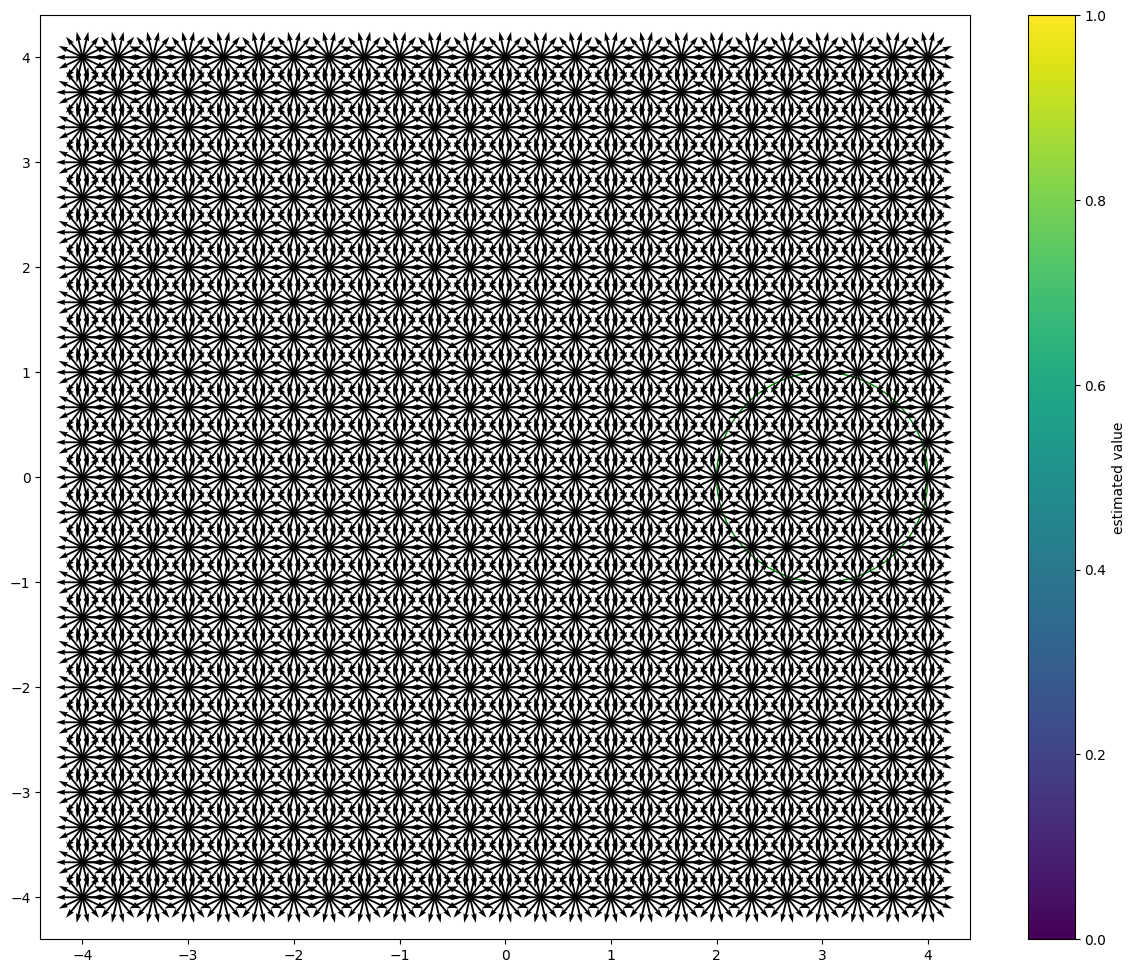

In [9]:
X_attacker = np.array([x['attacker'] for x in X])
plot_surface(X_attacker, env, None, [], [])

In [10]:
X

[{'attacker': array([-4., -4.,  0.], dtype=float32),
  'defender': array([-4., -4.,  0.], dtype=float32)},
 {'attacker': array([-4.        , -4.        ,  0.44879895], dtype=float32),
  'defender': array([-4., -4.,  0.], dtype=float32)},
 {'attacker': array([-4.       , -4.       ,  0.8975979], dtype=float32),
  'defender': array([-4., -4.,  0.], dtype=float32)},
 {'attacker': array([-4.       , -4.       ,  1.3463968], dtype=float32),
  'defender': array([-4., -4.,  0.], dtype=float32)},
 {'attacker': array([-4.       , -4.       ,  1.7951958], dtype=float32),
  'defender': array([-4., -4.,  0.], dtype=float32)},
 {'attacker': array([-4.       , -4.       ,  2.2439947], dtype=float32),
  'defender': array([-4., -4.,  0.], dtype=float32)},
 {'attacker': array([-4.       , -4.       ,  2.6927936], dtype=float32),
  'defender': array([-4., -4.,  0.], dtype=float32)},
 {'attacker': array([-4.       , -4.       ,  3.1415927], dtype=float32),
  'defender': array([-4., -4.,  0.], dtype=float

In [11]:
def encode(X):
    X = np.array(list(map(lambda row: (row['attacker'][0], row['attacker'][1], np.cos(row['attacker'][2]), np.sin(row['attacker'][2]), row['defender'][0], row['defender'][1], np.cos(row['defender'][2]), np.sin(row['defender'][2])), X)))

    return X

X = encode(X)
X


array([[-4.        , -4.        ,  1.        , ..., -4.        ,
         1.        ,  0.        ],
       [-4.        , -4.        ,  0.90096885, ..., -4.        ,
         1.        ,  0.        ],
       [-4.        , -4.        ,  0.6234898 , ..., -4.        ,
         1.        ,  0.        ],
       ...,
       [ 4.        ,  4.        ,  0.6234896 , ..., -4.        ,
         1.        ,  0.        ],
       [ 4.        ,  4.        ,  0.90096885, ..., -4.        ,
         1.        ,  0.        ],
       [ 4.        ,  4.        ,  1.        , ..., -4.        ,
         1.        ,  0.        ]], dtype=float32)

In [12]:
print(len(X))
print(len(y))

9375


NameError: name 'y' is not defined

In [13]:
# %%capture
# #generate data
# env = TwoPlayerDubinsCarEnv()

# state = env.reset()
# X = []
# y = []
# for i in range(50000):
#     for player in env.players:
#         state = env.reset()
#         X.append(np.hstack([state['attacker'], state['defender']]))


# X = np.array(X)



In [14]:
len(X)

9375

In [38]:

def forward(X):
    l1 = hk.Linear(128)(X)
    l2 = jax.nn.relu(l1)
    l3 = hk.Linear(128)(l2)
    l4 = jax.nn.relu(l3)
    l5 = hk.Linear(128)(l4)
    l6 = jax.nn.relu(l5)

    l7= hk.Linear(1)(l6)

    return l7

# a transformed haiku function consists of an 'init' and an 'apply' function
forward = hk.without_apply_rng(hk.transform(forward))



# initialize parameters
rng = jax.random.PRNGKey(seed=14)
params = forward.init(rng, X)

# redefine 'forward' as the 'apply' function
forward = jax.jit(forward.apply)

@jax.jit
def loss_fn(params, X, y):
    err = forward(params, X) - y
    return jnp.mean(jnp.square(err))  # mse




optimizer = optax.adamw(learning_rate=10e-5)
batch_size = 100 #make it 200
losses = [np.inf]
val_losses = [np.inf]
#check we aren't double using gradients
opt_state = optimizer.init(params)
gamma = 0.8

@jax.jit
def train_step(params, X_batch, y_batch, opt_state):
    loss, grads = jax.value_and_grad(loss_fn)(params, X=X_batch, y=y_batch)
    #updates, opt_state = optimizer.update(grads, opt_state)
    updates, opt_state = optimizer.update(grads,params=params, state= opt_state)

    params = optax.apply_updates(params, updates)
    return loss, params, opt_state

FIRST = False

for epoch in range(15):
    epoch_loss = 0.0
    opt_state = optimizer.init(params)
    for batch in range(0, len(X), batch_size):
        X_batch = X[batch:batch+batch_size]


        if FIRST:
            y_batch = ys[batch:batch+batch_size]
            #print(np.unique(y_batch, return_counts=True))
        else:
            y_batch = env.sample_value_iter(X_batch, forward, params, gamma=gamma)
        loss, params, opt_state = train_step(params, X_batch, y_batch, opt_state)
        epoch_loss += loss
    FIRST = False
    epoch_loss /= (len(X) // batch_size)

    # y_val = env.sample_value_iter(X_val, forward, params, gamma=gamma)

    # val_loss = loss_fn(params, X_val, y_val)
    # print("val_loss", val_loss, 'delta' , np.abs(val_loss - val_losses[-1]))
    # if val_losses[-1] - val_loss < 0.0001:
    #     print("early stopping",val_losses[-1] - val_loss)
    #     break
    # val_losses.append(val_loss)


    print('epoch', epoch, 'average loss', epoch_loss, 'epoch delta', np.abs(epoch_loss - losses[-1]))
    losses.append(epoch_loss)

#todo impolement val set for early stopping


epoch 0 average loss 0.10707348 epoch delta inf
epoch 1 average loss 0.09662852 epoch delta 0.0104449615
epoch 2 average loss 0.0911886 epoch delta 0.0054399148
epoch 3 average loss 0.08665986 epoch delta 0.0045287386
epoch 4 average loss 0.085248016 epoch delta 0.0014118478
epoch 5 average loss 0.08481692 epoch delta 0.00043109804
epoch 6 average loss 0.08408581 epoch delta 0.0007311106
epoch 7 average loss 0.083346985 epoch delta 0.0007388219
epoch 8 average loss 0.082612365 epoch delta 0.0007346198
epoch 9 average loss 0.08196703 epoch delta 0.00064533204
epoch 10 average loss 0.08149209 epoch delta 0.0004749447
epoch 11 average loss 0.08096862 epoch delta 0.00052347034
epoch 12 average loss 0.080788754 epoch delta 0.00017986447
epoch 13 average loss 0.080839 epoch delta 5.0246716e-05
epoch 14 average loss 0.08079684 epoch delta 4.2162836e-05


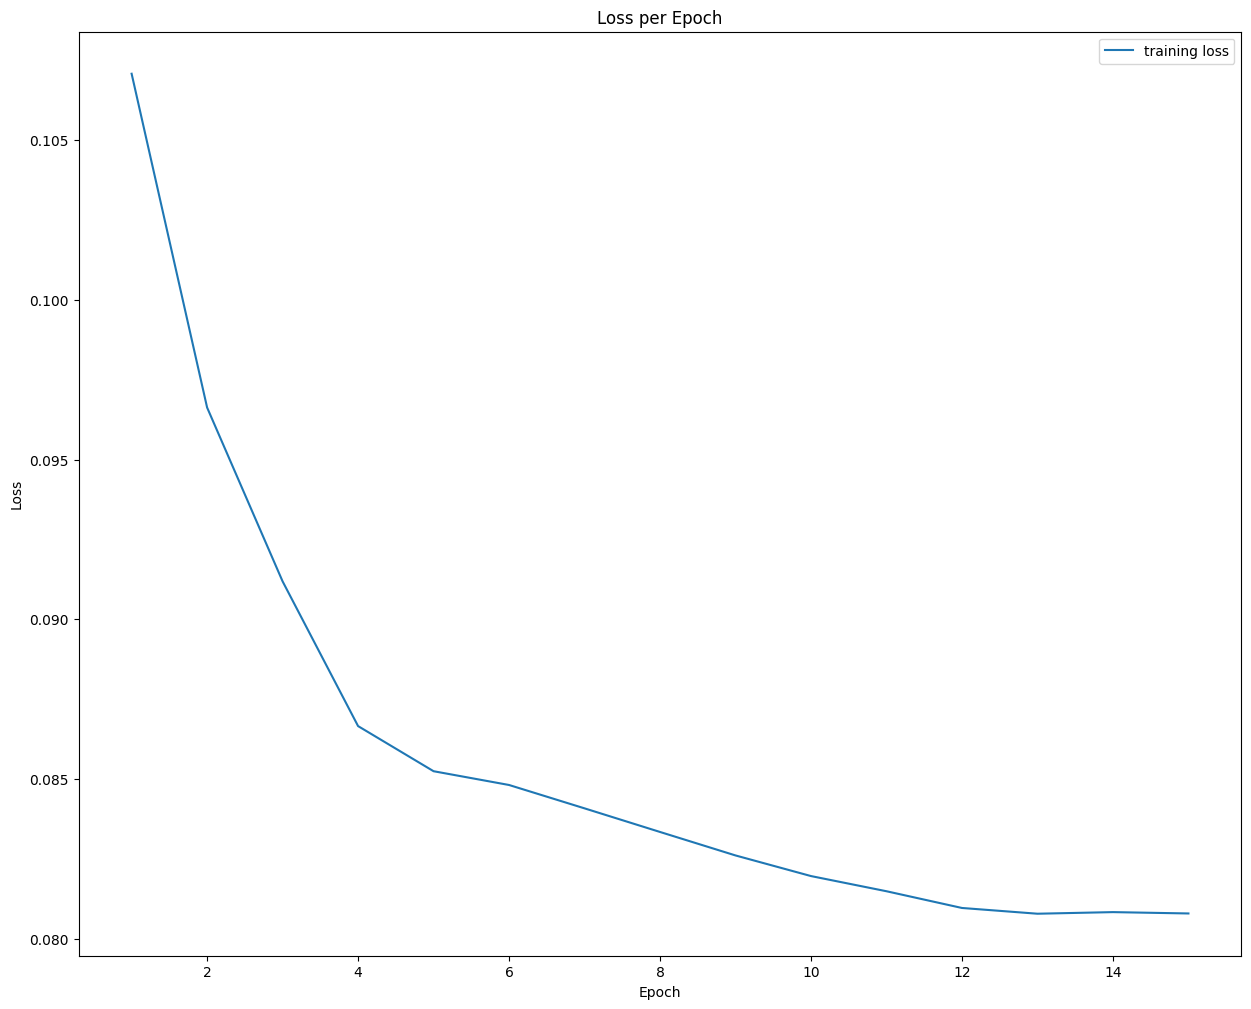

In [39]:
# Plot the losses
%matplotlib inline

lo = [l for l in losses]
#vlo = [l for l in val_losses]


plt.plot(lo, label='training loss')
#plt.plot(vlo, label='validation loss')

# Add a title and labels to the x and y axis
plt.legend()
plt.title("Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")

# Show the plot

plt.show()

In [25]:
# env = TwoPlayerDubinsCarEnv()
# state = env.reset()
# done = False
# max_iter = 50
# counter = 0
# print(env.state)
# while (not done) and (counter < max_iter):
#     counter+=1
#     possible_actions = []
#     for d_action in range(env.action_space['defender'].n):
#         state_ , reward, done, info = env.step(state, d_action, 'defender')
#         defender_actions = []
#         for a_action in range(env.action_space['attacker'].n):
#             next_state, reward, _, _ = env.step(state_, a_action, 'attacker')
#             #input = np.hstack([next_state['attacker'], next_state['defender']])
#             nn_input = env.state_for_nn(next_state)
#             estimate  = forward(X=nn_input, params=params)
#             print('estimate', estimate, 'actual', reward)
#             possible_actions.append([d_action, a_action, estimate[0]])
#         pa = np.array(possible_actions)
#     cand_attack_actions = np.argmax(pa.T,axis=0)
#     best_defender_action =  np.argmin(np.max(pa.T,axis=0))
#     best_attacker_action = cand_attack_actions[best_defender_action]
#     print(counter)
#     print('best defender action', best_defender_action, 'best attacker action', best_attacker_action)
#     print(env.state)

#     state, reward, done, _ = env.step(action=best_defender_action, player='defender', update_env=True)
#     #state, reward, done, _ = env.step(action=best_attacker_action, player='attacker', update_env=True)

#     env.render()
    
# env.make_gif()

{'attacker': array([-1.5498685 ,  2.4511783 ,  0.81426126], dtype=float32), 'defender': array([-0.8775566, -3.9365213,  4.8966017], dtype=float32)}
estimate [-0.13975853] actual 0
estimate [-0.14040552] actual 0
estimate [-0.18875167] actual 0
estimate [-0.14247812] actual 0
estimate [-0.14295587] actual 0
estimate [-0.1985466] actual 0
estimate [-0.04649051] actual 0
estimate [-0.04760687] actual 0
estimate [-0.13744986] actual 0
1
best defender action 0 best attacker action 0
{'attacker': array([-1.1621563 ,  2.4658332 ,  0.81426114], dtype=float32), 'defender': array([-0.9497542, -4.0438232,  4.8966017], dtype=float32)}
estimate [-0.11226199] actual 0
estimate [-0.11203356] actual 0
estimate [-0.15638223] actual 0
estimate [-0.112444] actual 0
estimate [-0.11156781] actual 0
estimate [-0.15796088] actual 0
estimate [0.00603581] actual 0
estimate [0.00960484] actual 0
estimate [-0.04360221] actual 0
2
best defender action 0 best attacker action 0
{'attacker': array([-0.9375614,  2.10

In [59]:
right = 0.0
up = np.pi / 2
down = 3 * np.pi / 2
left = np.pi

env = TwoPlayerDubinsCarEnv()
#state = env.reset()
state = env.set(-3, 3, down,-2, 2, up)
done = False
max_iter = 100
counter = 0
print(env.state)

while (not done) and (counter < max_iter):
    counter += 1
    pa = []
    for d_action in range(env.action_space['defender'].n):
        possible_actions = []  # Initialize possible_actions inside the d_action loop
        state_, reward, done, defender_info = env.step(state, d_action, 'defender')
        for a_action in range(env.action_space['attacker'].n):
            next_state, reward, done, info_attacker = env.step(state_, a_action, 'attacker')

            if info_attacker['player'] == 'attacker' and not info_attacker['is_legal']:
                possible_actions.append([d_action, a_action, -np.inf])
                print('illegal move')
                # If the attacker's move is illegal, skip it
            elif defender_info['status'] == 'eaten':
                done = True
                possible_actions.append([d_action, a_action, -1])

            else:
                nn_input = env.state_for_nn(next_state)
                estimate = forward(X=nn_input, params=params)
                possible_actions.append([d_action, a_action, estimate[0]])
        pa.append(possible_actions)
    print('pa', pa)
    print(len(pa))
    pa = np.array(pa)[:, :, 2].T
    if np.all(pa == -np.inf):
        print('all illegal moves')
        break


    cand_attack_actions = np.argmax(pa, axis=0)
    best_defender_action = np.argmin(np.max(pa, axis=0))
    best_attacker_action = cand_attack_actions[best_defender_action]
    print(counter)
    print('best defender action', best_defender_action, 'best attacker action', best_attacker_action)
    print(env.state)

    state, reward, done, _ = env.step(action=best_defender_action, player='defender', update_env=True)
    state, reward, done, _ = env.step(action=best_attacker_action, player='attacker', update_env=True)

    env.render()
    
env.make_gif()


{'attacker': array([-3.      ,  3.      ,  4.712389], dtype=float32), 'defender': array([-2.       ,  2.       ,  1.5707964], dtype=float32)}
pa [[[0, 0, Array(-0.3172201, dtype=float32)], [0, 1, Array(-0.21390063, dtype=float32)], [0, 2, Array(-0.19282815, dtype=float32)]], [[1, 0, Array(-0.307504, dtype=float32)], [1, 1, Array(-0.19301108, dtype=float32)], [1, 2, Array(-0.16264486, dtype=float32)]], [[2, 0, Array(-0.3604148, dtype=float32)], [2, 1, Array(-0.18995316, dtype=float32)], [2, 2, Array(-0.1634704, dtype=float32)]]]
3
1
best defender action 0 best attacker action 2
{'attacker': array([-3.      ,  3.      ,  4.712389], dtype=float32), 'defender': array([-2.       ,  2.       ,  1.5707964], dtype=float32)}
pa [[[0, 0, Array(-0.24471179, dtype=float32)], [0, 1, Array(-0.18051022, dtype=float32)], [0, 2, Array(-0.35757458, dtype=float32)]], [[1, 0, Array(-0.2071976, dtype=float32)], [1, 1, Array(-0.18517981, dtype=float32)], [1, 2, Array(-0.3691349, dtype=float32)]], [[2, 0, Ar

In [41]:
y_train = [forward(X=x, params=params) for x in X]


[0.25       0.22524221 0.15587245 ... 0.1558724  0.22524221 0.25      ]


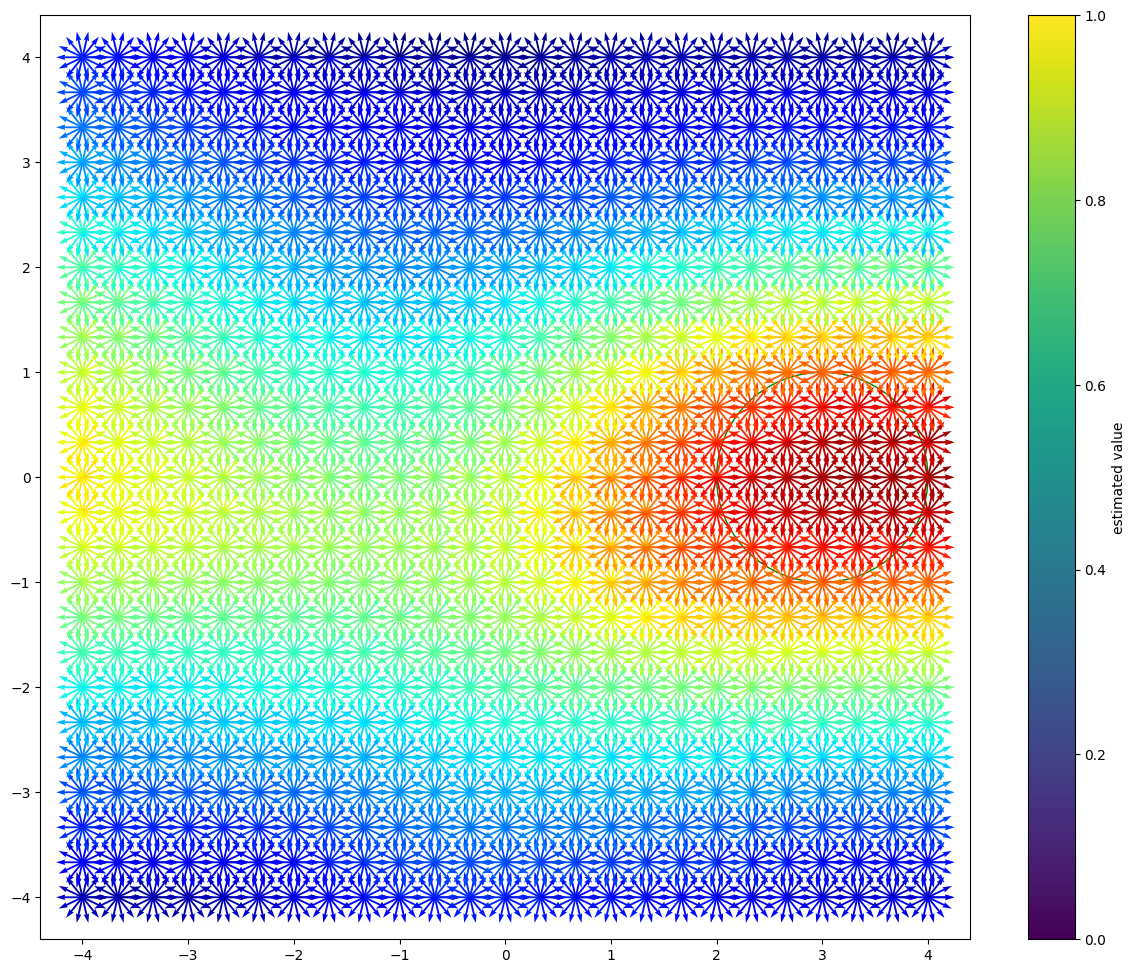

In [42]:
plot_surface(X_attacker, env, 'experiment2.png', y_train)

In [ ]:
pa = np.array(possible_actions)
pa = pa[:,2].reshape(3,3)
pa

In [ ]:
best_attacker_moves = np.argmax(pa.T,axis=0)

best_defender_move =  np.argmin(np.max(pa.T,axis=0))

best_attacker_move = best_attacker_moves[best_defender_move]
print(best_defender_move,best_attacker_move)


In [ ]:
pa[best_defender_move][best_attacker_move]

In [ ]:
possible_actions